In [1]:
import re
import os
import boto3
import configparser

import numpy as np
import pandas as pd
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
config = configparser.ConfigParser()
config.read_file(open('awskey.cfg'))
CAPSTONE_AWS_ACCESS_KEY_ID = config.get('capstone', 'AWS_ACCESS_KEY_ID')
CAPSTONE_AWS_SECRET_ACCESS_KEY = config.get('capstone', 'AWS_SECRET_ACCESS_KEY')

In [3]:
s3_creds = {'region_name':"us-west-2",
            'aws_access_key_id': CAPSTONE_AWS_ACCESS_KEY_ID,
            'aws_secret_access_key': CAPSTONE_AWS_SECRET_ACCESS_KEY}
                          
client = boto3.client('s3', **s3_creds)
resource = boto3.resource('s3', **s3_creds)
bucket = resource.Bucket('us-immigration')

### Step 1: Scope the Project and Gather Data

#### Scope 
The purpose of this project is to provide a deep dive into US immigration, primiarily focusing on the type of visas being issued and the profiles associated. The scope of this project is limited to the data sources listed below with data being aggregated across numerous features such as visatype, gender, port_of_entry, nationality and month.

#### Data Description & Sources 
- I94 Immigration Data: This data comes from the US National Tourism and Trade Office found [here](https://travel.trade.gov/research/reports/i94/historical/2016.html). Each report contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries).
- World Temperature Data: This dataset came from Kaggle found [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).
- U.S. City Demographic Data: This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. Dataset comes from OpenSoft found [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
- Airport Code Table: This is a simple table of airport codes and corresponding cities. The airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia). It comes from [here](https://datahub.io/core/airport-codes#data).

In [13]:
bucket = resource.Bucket('us-immigration')
#csv_files = [o.key for o in bucket.objects.filter(Prefix="Dimensions") if '.csv' in o.key]
csv_files = [o.key for o in bucket.objects.all() if '.csv' in o.key]
print(f"{len(csv_files)} csv files")

13 csv files


In [5]:
csv_files

['GlobalLandTemperaturesByCity.csv',
 'airport_codes.csv',
 'i94addr.csv',
 'i94cit_i94res.csv',
 'i94mode.csv',
 'i94port.csv',
 'i94visa.csv',
 'immigration_data_sample.csv',
 'nationality_codes.csv',
 'port_of_entry_codes.csv',
 'us_cities_demographics.csv',
 'visa_codes.csv',
 'visa_post.csv']

In [6]:
data = {}
for file in csv_files:
    data[file.replace('.csv', '')] = pd.read_csv(client.get_object(Bucket='us-immigration', Key=file)['Body'])

In [7]:
for k,v in data.items():
    k
    v.head()

'GlobalLandTemperaturesByCity'

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


'airport_codes'

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


'i94addr'

,code,state
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona
3,AR,Arkansas
4,CA,California


'i94cit_i94res'

,code,country
0,582,"Mexico Air Sea, And Not Reported (I-94, No Lan..."
1,236,Afghanistan
2,101,Albania
3,316,Algeria
4,102,Andorra


'i94mode'

,code,transportation
0,1,Air
1,2,Sea
2,3,Land


'i94port'

,code,port_of_entry,city,state_or_country
0,ALC,"Alcan, Ak",Alcan,Ak
1,ANC,"Anchorage, Ak",Anchorage,Ak
2,BAR,"Baker Aaf - Baker Island, Ak",Baker Aaf - Baker Island,Ak
3,DAC,"Daltons Cache, Ak",Daltons Cache,Ak
4,PIZ,"Dew Station Pt Lay Dew, Ak",Dew Station Pt Lay Dew,Ak


'i94visa'

,code,reason_for_travel
0,1,Business
1,2,Pleasure
2,3,Student


'immigration_data_sample'

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


'nationality_codes'

,code,Nationality
0,AFGH,Afghanistan
1,ALB,Albania
2,ALGR,Algeria
3,ANDO,Andorra
4,ANGL,Angola


'port_of_entry_codes'

,code,city,state
0,ABE,Aberdeen,WA
1,ABG,Alburg,VT
2,ABQ,Albuquerque,NM
3,ABS,Alburg Springs,VT
4,ADT,Amistad Dam,TX


'us_cities_demographics'

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


'visa_codes'

,class_of_admission,ins_status_code,description,section_of_law
0,203(a)(7),RE,Conditional Entrant,Pursuant to Section 203(a)(7) of the INA
1,207/Refugee,RF,Refugee,Pursuant to Section 207 of the INA
2,208,AS,Asylee,Pursuant to Section 208 of the INA
3,243(h) or 241(b)(3),DW,Withholding of deportation or removal,Pursuant to Section 243(h) or 241(b)(3)
4,"AM 1,2,3",AM,Amerasian,Amerasian


'visa_post'

,visapost,visapost_fullname
0,ABJ,Abidjan
1,ABD,Abu Dhabi
2,BRF,Abu Dhabi (Beirut Files)
3,ABU,Abuja
4,ACC,Accra


In [11]:
data['GlobalLandTemperaturesByCity'].dtypes

Unnamed: 0                         int64
dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

In [15]:
data['immigration_data_sample'].merge(data['visa_codes'], left_on='visatype', right_on='class_of_admission'
                                     ).groupby(['gender','visatype'])[['cicid']].count()

cicid
gender visatype       
F      CP            3
       WB           12
       WT          184
M      CP            2
       WB           44
       WT          182
X      WT            1

In [8]:
data['port_of_entry_codes']

,code,city,state
0,ABE,Aberdeen,WA
1,ABG,Alburg,VT
2,ABQ,Albuquerque,NM
3,ABS,Alburg Springs,VT
4,ADT,Amistad Dam,TX
5,AGA,Agana,Guam
6,AGM,Algoma,WI
7,AGN,Algonac,MI
8,AGU,Mayaguez,PR
9,AKR,Akron,OH


#### Airport Data
-------------------------------------------

In [16]:
data['airport_codes'].head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [17]:
pd.DataFrame(data['airport_codes']['coordinates'].head().str.split(',').tolist(), columns=['Latitude', 'Longitude'])

,Latitude,Longitude
0,-74.93360137939453,40.07080078125
1,-101.473911,38.704022
2,-151.695999146,59.94919968
3,-86.77030181884766,34.86479949951172
4,-91.254898,35.6087


#### Cities Data
-------------------------------------------

In [18]:
data['us_cities_demographics'].shape

(2891, 12)

### This data looks pretty clean. The exploration steps involve:
Looking at a single city. This reveals the grain of the table to be city/state/race. Removing the Race and Count columns gives you duplicate data
- Assuring that the Male Population and Female Population numbers add up to Total Population whenever they are present. (NB: I am aware not everybody identifies as exactly one of those two genders, but they always add up to total in this table so I assume those were the only two choices and were required.)
- Assuring that Number of Veterans, Race, and Foreign-born are less than Total Population whenever they are present.
- Seeing that the total of Count for all the races adds up to more than Total Population, indicating people must have been allowed to select more than one race for themselves in the survey.
- Selecting distinct state codes to be sure that the number was near 50 (to account for 50 states, DC, PR, etc.)
- Those are important things to learn, but there was nothing in this data that needed cleaning.

data['us_cities_demographics'].head()

In [12]:
# Looking at one city reveals grain to be city/state/race
city_demo_df=data['us_cities_demographics']
city_demo_df[city_demo_df['City'] == 'Silver Spring'].head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.6,MD,Hispanic or Latino,25924
592,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.6,MD,White,37756
1678,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.6,MD,Black or African-American,21330
2123,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.6,MD,American Indian and Alaska Native,1084
2162,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.6,MD,Asian,8841


In [13]:
# Ensure counts, when present, don't exceed total population, and that male+female == total
for _, row in city_demo_df.iterrows():
    if pd.notnull(row['Male Population']):
        assert row['Male Population'] + row['Female Population'] == row['Total Population']
    if pd.notnull(row['Number of Veterans']):
        assert row['Number of Veterans'] <= row['Total Population']
    if pd.notnull(row['Foreign-born']):
        assert row['Foreign-born'] <= row['Total Population']
    if pd.notnull(row['Count']):
        assert row['Count'] <= row['Total Population']
    for numbered_column in ['Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born', 'Count']:
        assert pd.isnull(row[numbered_column]) or row[numbered_column] > 0
        
# Check to see if race counts add up to total
sub_df = city_demo_df[['City', 'State', 'Total Population', 'Count']]
grouped = sub_df.groupby(['City', 'State', 'Total Population']).sum().reset_index()
grouped.head()

,City,State,Total Population,Count
0,Abilene,Texas,125876,147900
1,Akron,Ohio,197553,210305
2,Alafaya,Florida,85264,115476
3,Alameda,California,78614,89174
4,Albany,Georgia,71109,73478


In [14]:
# Based on that last run it looks like Count always sums up to >= Total Population, so let's check
for _, row in grouped.iterrows():
    if pd.notnull(row['Total Population']) and row['Count'] < row['Total Population']:
        print(row['City'], row['State'], row['Total Population'], row['Count'])

Bayamón Puerto Rico 170259 169155
Caguas Puerto Rico 77008 76973
Mayagüez Puerto Rico 66581 65756
New Bedford Massachusetts 94959 93321
Ponce Puerto Rico 121583 120705
San Juan Puerto Rico 342237 342042
South Jordan Utah 66639 66205


In [15]:
# Let's get some totals by state now, in large part to verify that we only have ~ 50 states listed
sub_df = city_demo_df[['State Code', 'Male Population', 'Female Population', 'Total Population', 'Foreign-born']]
summed_by_state_df = sub_df.groupby(['State Code']).sum().reset_index()
print(summed_by_state_df.shape)
summed_by_state_df.sort_values(by=['Total Population'], ascending=False).head()  # reveals 49 rows, which is great, and topped by big states like CA, TX, and NY passes sniff test

(49, 5)


,State Code,Male Population,Female Population,Total Population,Foreign-born
4,CA,61055672.0,62388681.0,123444353,37059662.0
44,TX,34862194.0,35691659.0,70553853,14498054.0
34,NY,23422799.0,25579256.0,49002055,17186873.0
9,FL,15461937.0,16626425.0,32306132,7845566.0
14,IL,10943864.0,11570526.0,22514390,4632600.0


### Weather Data

In [20]:
data['GlobalLandTemperaturesByCity'].shape

(8599212, 8)

In [21]:
data['GlobalLandTemperaturesByCity'].head()

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


#### Immigration Data
-------------------------------------------

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField,StringType,DoubleType,IntegerType,TimestampType,DateType
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as funcToInt
spark = SparkSession\
        .builder\
        .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0")\
        .enableHiveSupport()\
        .getOrCreate()

sc=spark.sparkContext
hadoop_confg=sc._jsc.hadoopConfiguration()
hadoop_confg.set("fs.s3a.impl", "org.apache.hadoop.fs.s3native.NativeS3FileSystem")
hadoop_confg.set("fs.s3a.awsAccessKeyId", CAPSTONE_AWS_ACCESS_KEY_ID)
hadoop_confg.set("fs.s3a.awsSecretAccessKey", CAPSTONE_AWS_SECRET_ACCESS_KEY)
df = spark.read.parquet("s3a://us-immigration/i94_parquet_data/*.parquet")

In [ ]:
df.printSchema()

In [ ]:
import datetime
s = "01232017"
#s_datetime = datetime.datetime.strptime(s, '%Y%m%d')
#s_datetime = datetime.datetime.strptime(s, '%m%d%Y')
print(s_datetime)

In [ ]:
df.groupby(['gender','visatype']).agg({'count': 'count'}).collect()

### Step 2: Explore and Preprocessing Data
Note: preprocessing was performed prior to storing CSV files in S3 buckets i.e. converting expanding columns, Capitalizing/Lowercasing test etc.
#### Explore Data 
- Identify missing values
- Identify duplicate values

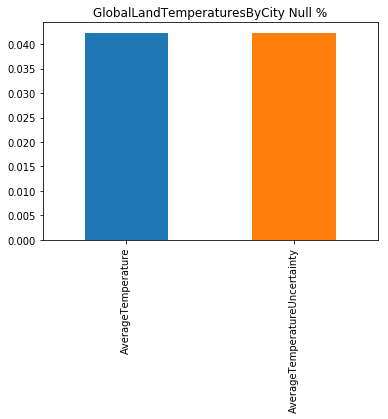

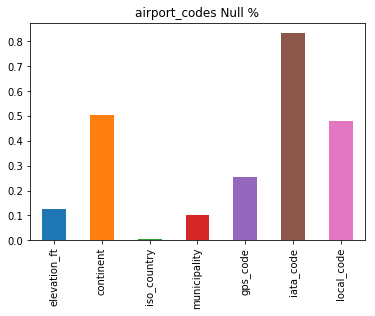

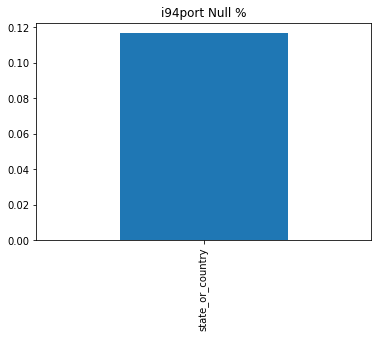

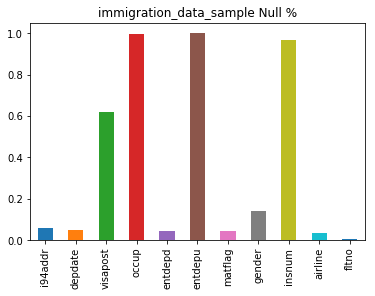

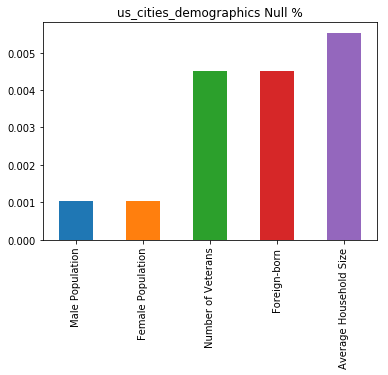

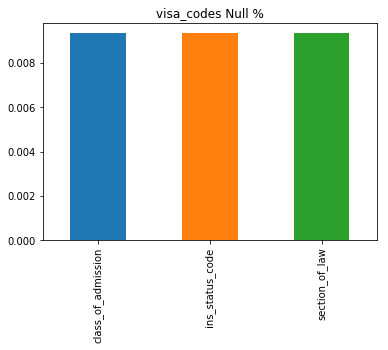

In [23]:
for k,v in data.items():
    null_count = v.isnull().sum()
    if null_count.sum()>0:
        ax = (null_count[null_count>0]/v.shape[0]).plot(kind='bar', title=f"{k} Null %")
        plt.show()

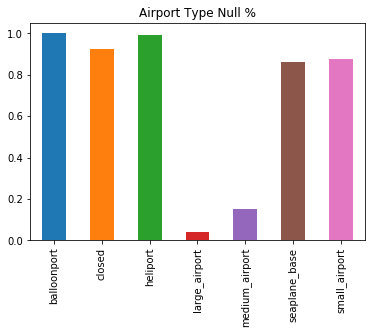

In [24]:
ax = (data['airport_codes'][data['airport_codes'].iata_code.isnull()].type.value_counts()/
      data['airport_codes'].type.value_counts()).plot(kind='bar', title=f"Airport Type Null %")

The above provides further insight into the majority of null values in the airport data. Specifically, majority of null values associated with airport data stem from missing `iata_codes`. Upon further investigation it appears that the lesser important airports associated with immigration, namely, `balloon ports, closed, heliports, seaplanes and small airports` do not have corresponding `iata_codes` information.

#### Cleaning Steps
- Either drop rows or fill missing data with median values where appropriate
- Expand coordinates to Latitude & Longitude columns
- Expand locations to City & State columns
e.g. the data provided for `port_of_entry_codes` was originally `code` and `location`. These have subsequently been expanded out to `city` and `state_or_country` as shown below:

In [ ]:
data['port_of_entry_codes'][['code', 'city','state']]

### Step 3: Data Model
<img src="./images/schema.png"/>

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Creating the data model involves various steps, which can be made significantly easier through the use of Airflow. The process of extracting files from S3 buckets, transforming the data and then writing CSV and PARQUET files to Redshift is accomplished through various tasks highlighted below in the ETL Dag graph. These steps include:
- Extracting data from SAS Documents and writing as CSV files to S3 immigration bucket
- Extracting remaining CSV and PARQUET files from S3 immigration bucket
- Writing CSV and PARQUET files from S3 to Redshift
- Performing data quality checks on the newly created tables
<img src="images/FinalDataPipeline.png"/>

#### 4.2 Data Quality Checks
Data quality checks include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness

#### Check Tables

In [4]:
config = configparser.ConfigParser()
config.read_file(open('awskey.cfg'))
CAPSTONE_REDSHIFT_USER = config.get('redshift', 'CAPSTONE_REDSHIFT_USER')
CAPSTONE_REDSHIFT_PASSWORD = config.get('redshift', 'CAPSTONE_REDSHIFT_PASSWORD')
CAPSTONE_HOST = config.get('redshift', 'CAPSTONE_HOST')
CAPSTONE_PORT = config.get('redshift', 'CAPSTONE_PORT')
CAPSTONE_DB = config.get('redshift', 'CAPSTONE_DB')

from sqlalchemy import create_engine
eng = create_engine(f'postgres://{CAPSTONE_REDSHIFT_USER}:{CAPSTONE_REDSHIFT_PASSWORD}@{CAPSTONE_HOST}:{CAPSTONE_PORT}/{CAPSTONE_DB}')

In [5]:
qry = eng.execute("""
SELECT TABLE_NAME
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE = 'BASE TABLE' AND TABLE_CATALOG='dev'
""")
tables = pd.DataFrame([{**row} for row in qry]).tail(12)
tables

,table_name
151,nationality_codes
152,i94port
153,i94cit_i94res
154,i94visa
155,us_cities_demographics
156,i94mode
157,visa_codes
158,visa_post
159,port_of_entry_codes
160,airport_codes


In [7]:
qry = eng.execute("""select * from i94mode;""")
pd.DataFrame([{**row} for row in qry])

,code,transportation
0,1,Air
1,2,Sea
2,3,Land


In [8]:
tables['table_name'][1:]

152                         i94port
153                   i94cit_i94res
154                         i94visa
155          us_cities_demographics
156                         i94mode
157                      visa_codes
158                       visa_post
159             port_of_entry_codes
160                   airport_codes
161    globallandtemperaturesbycity
162                     immigration
Name: table_name, dtype: object

#### Check Distinct Rows

In [9]:
def get_col_from_table(table, col=0):
    qry = eng.execute(f"select * from {table} limit 1;")
    return pd.DataFrame([{**row} for row in qry]).columns[col]

for table in tables['table_name'][1:]:
    column = get_col_from_table(table)
    sql = f"SELECT COUNT(DISTINCT {column}) FROM {table};"
    c = eng.execute(sql).fetchone()[0]
    print(f"{table}:\n\t{c} distinct rows for column {column}\n")

i94port:
	634 distinct rows for column city

i94cit_i94res:
	288 distinct rows for column code

i94visa:
	3 distinct rows for column code

us_cities_demographics:
	161 distinct rows for column average_household_size

i94mode:
	3 distinct rows for column code

visa_codes:
	105 distinct rows for column class_of_admission

visa_post:
	284 distinct rows for column visapost

port_of_entry_codes:
	387 distinct rows for column city

airport_codes:
	7 distinct rows for column continent

globallandtemperaturesbycity:
	111994 distinct rows for column averagetemperature

immigration:
	732472 distinct rows for column admnum



#### Basic Study of Visa Counts by Gender

In [10]:
qry = eng.execute("""
SELECT 
    im.gender, 
    im.visatype,
    count(im.cicid) 
FROM immigration as im 
    JOIN visa_codes 
    ON im.visatype = visa_codes.class_of_admission 
GROUP BY im.gender, im.visatype
""")

qry_df = pd.DataFrame([{**row} for row in qry])

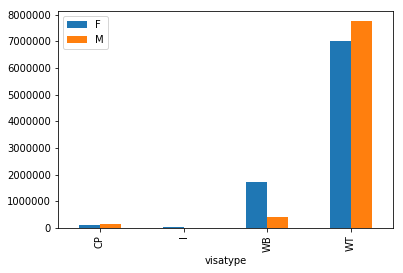

In [11]:
df = qry_df.set_index(['visatype', 'gender']).unstack()[[('count', 'M'),('count', 'F')]]
df.columns=['F', 'M']
df.plot(kind='bar');

#### 4.3 Data dictionary 
Create a data dictionary for entire system and data model. For each field, provide a brief description of what the data is and where it came from. 

### Fact Table : Immigration
The grain is an immigration event

* immigration_id: primary key
- i94yr: 4 digit year
- i94mon: numeric month
- i94cit & i94res: valid & invalid codes for processing
- i94port: valid & invalid codes for processing
- arrdate: arrival date in USA. SAS date numeric field.
- i94mode: 1 = 'Air', 2 = 'Sea', 3 = 'Land', 9 = 'Not Reported'
- i94addr: 
- i94bir: age of respondent in years
- i94 visa: visa code, 1 = 'Business', 2 = 'Pleasure', 3 = 'Student'
- count: summary statistics
- dtadfile: character date field
- visapost: department of state where visa was issued
- occup: occupation performed in the U.S.
- entdepa: arrival flag - admitted or paroled into the U.S.
- entdepu: update flag - apprehended or overstayed, adjusted to perm residence
- matflag: match flag - match of arrival and departure records
- biryear: 4 digit year of birth
- dtaddto: chracter date field - date to which admitted to U.S.
- gender
- insnum: INS number
- airline: airline sued to arrive in U.S.
- admnum - admission number
- fltnoL flight number of airline used to arrive in U.S.
- visatype: class of admission legally admitting the non-immigrant to temporarily stay in U.S.

### Dimension : US_Cities
Provides population statistics on cities in the US. Grain is city/state/race.
* city: city's name
* state: state city is in
* median_age: median age of city
* male_pop: number of men in the city
* female_pop: number of women in the city
* total_pop: number of people in the city
* num_vets: number of veterans in the city
* foreign_born: number of foreign-born people in the city
* avg_household_size: average household size
* state_code: two-letter code for state
* race: White, Hispanic or Latino, Asian, Black or African-American, or American Indian and Alaska Native
* count: number of people of that race in the city

### Dimension : i94addr
* code : Add code
* state : State information

### Dimension : i94port:
* code : Code for the port
* port_of_entry : port name
* city : port is in which city
* state_or_country : port is in which state or country

### Dimension : i94cit_i94res:
* code: Code for the country
* country : country name

### Dimension : i94visa:
* code: 1, 2, or 3
* reason_for_travel: Business, Pleasure, or Student, respectively

### Dimension : i94mode:
How immigrants arrived. Foreign key to fact immigration.i94mode
* code: 1, 2, 3, or 9
* transportation: Air, Sea, Land, or Not reported, respectively


### Dimension : visa_codes:
* class_of_admission :
* ins_status_code :
* description :
* section_of_law :

### Dimension : visa_post:
* visapost : visa post code
* visapost_fullname :visa post name

### Dimension : port_of_entry_codes:
* code : port code
* Location : port location
* city : port belongs which city
* state_or_country : port is in which state or country

### Dimension : airport_codes:
* ident :
* type :
* name :
* elevation_ft:
* continent :
* iso_country :
* iso_region :
* municipality :
* gps_code :
* iata_code :
* local_code :
* coordinates :
* lat :
* long:

### Dimension : weather:
* dt :
* AverageTemperature:
* AverageTemperatureUncertainty:
* city :
* Country :
* Latitude :
* Longitude :

#### Step 5: Complete Project Write Up

## Tools and technologies
I chose Python,Pandas,AWS S3,AWS RedShift,AirFLow and PySpark because it can easily read all the data formats provided and then easily get them into a relational database.
The data was structured and formatted well enough to make using a SQL relational database a good fit, as it would provide a nice underpinning for an easily queryable star schema. I chose Postgres because it is fast and robust.

## Data Model
I chose to augment the immigration data with the city and state dimensions because the i94addr column indicates the state where the entrants have an address. This allowed me to see what states immigrants were heading to, along with whether, say, those states have a higher-percentage of foreign-born residents already, whether men are heading to states with a higher-percentage of women, etc.

## Updates
Fact immigration needs to be updated monthly when each new dataset is available with a header file, all dimension tables source from the immigration data can be dropped and recreated completely as above city and dim_state don't have a time component now. If new data is available in the future they should be updated at that time, ideally with date columns, at least by year date should be kept up to date. To be safe all dates between through 12/31/2099 should be added

## If things were different...
If the data were increased by 100 times, what is now a 10minutes load would become an untenable near about 16.7hour load. To avoid this, I would instead convert the fact immigration data to a format readable by Redshift Spectrum and land the data to S3, partitioned by date, and create an external schema so Redshift Spectrum could read it in a schema-on-read fashion and PySpark will move to multinode clusters.

Under this scenario, I could also ensure that the data was ready to populate a dashboard by seven AM every day as well. I have to assume I could get the daily data for fact immigration and, when it is avaialble, I could have an Airflow DAG using a S3Sensor that kicked off upon its arrival and then proceeded to parse the data, land it in its date-partitioned location in S3, in which case it would be ready for Redshift Spectrum to read immediately.

There should be no problem with 100 or so people accessing this data. However, the date-partitioned nature of the solution proposed above would also help in this case. If access by multiple users continues to be a problem you can mitigate that by having the data replicate to different nodes used by different users. If your users are located around the world, a replication node near each group of people would be best.
